In [1]:
import os
import torch
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader
import time

In [2]:
custom_transform = transforms.Compose([
                                       transforms.Resize((200,200)),
                                       transforms.ToTensor(),
                                       #transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
                                       #transforms.Grayscale(1) # not efficient
                                       ])

path = os.path.join(os.getcwd(), "#4 Garbage_classification")
folders = list()
test_dataset = []
train_dataset = []
validation_dataset = []

for folder in os.listdir(path):  folders.append(folder)

for folder_idx in range(len(folders)):
    fpath = os.path.join(path, folders[folder_idx])
    pics = list()
    
    for pic in os.listdir(fpath): pics.append(pic)
    num1 = int(len(pics)*0.8)
    num2 = int(len(pics)*0.1)
    
    for img in pics:
        im = Image.open(os.path.join(fpath, img))
        im = custom_transform(im)
        if img in pics[:num1]: train_dataset.append([im, folder_idx])
        elif img in pics[num1:num1+num2]: validation_dataset.append([im, folder_idx])
        else: test_dataset.append([im, folder_idx])

In [3]:
test_loader = DataLoader(dataset = test_dataset, batch_size = 8, shuffle = False)
train_loader = DataLoader(dataset = train_dataset, batch_size = 24, shuffle = True)
validation_loader = DataLoader(dataset = validation_dataset, batch_size = 8, shuffle = True)

In [4]:
# Alexnet model
import torch.nn
class Alexnet(torch.nn.Module):
    def __init__(self, in_channels = 3, num_classes = 12):
        super(Alexnet, self).__init__()

        self.block1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=in_channels,
                            out_channels=64,
                            kernel_size=(11, 11),
                            stride=(4, 4),
                            padding=2),
            torch.nn.ReLU(inplace = True),
            torch.nn.MaxPool2d(kernel_size=(3, 3),
                                stride=(2, 2))
        )
        self.block2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=64,
                            out_channels=192,
                            kernel_size=(5, 5),
                            stride=(1, 1),
                            padding=2),
            torch.nn.ReLU(inplace = True),
            torch.nn.MaxPool2d(kernel_size=(3, 3),
                                stride=(2, 2))
        )
        self.block3 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=192,
                            out_channels=384,
                            kernel_size=(3, 3),
                            stride=(1, 1),
                            padding=1),
            torch.nn.ReLU(inplace = True),
            torch.nn.Conv2d(in_channels=384,
                            out_channels=256,
                            kernel_size=(3, 3),
                            stride=(1, 1),
                            padding=1),
            torch.nn.ReLU(inplace = True),
            torch.nn.Conv2d(in_channels=256,
                            out_channels=256,
                            kernel_size=(3, 3),
                            stride=(1, 1),
                            padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=(3, 3),
                                stride=(2, 2))
        )

        self.avgpool = torch.nn.AdaptiveAvgPool2d((6,6))

        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(256*6*6,4096),
            torch.nn.ReLU(inplace = True),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096,4096),
            torch.nn.ReLU(inplace = True),
            torch.nn.Linear(4096,num_classes),    
        )
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.avgpool(x)
        x = torch.flatten(x,1)
        x = self.classifier(x)
        return x

In [ ]:
# Googlenet model

import torch.nn as nn

class Inception_block(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool):
        super(Inception_block, self).__init__()

        self.branch1 = conv_block(in_channels, out_1x1, kernel_size = 1)
        self.branch2 = nn.Sequential(
            conv_block(in_channels, red_3x3, kernel_size = 1),
            conv_block(red_3x3, out_3x3, kernel_size = 3,padding = 1)
        )
        self.branch3 = nn.Sequential(
            conv_block(in_channels, red_5x5, kernel_size = 1),
            conv_block(red_5x5, out_5x5, kernel_size = 5, padding=2)
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            conv_block(in_channels, out_1x1pool, kernel_size = 1)
        )
    
    def forward(self, x):
        return torch.cat([self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1)


class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(conv_block,self).__init__()
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
    
    def forward(self, x):
        return self.relu(self.batchnorm(self.conv(x)))
    

class GoogleNet(nn.Module):
    def __init__(self,in_channels = 3, num_classes = 12):
        super(GoogleNet, self).__init__()

        self.conv1 = conv_block(in_channels=in_channels, out_channels=64, kernel_size = (7,7),
                                stride = (2,2), padding = (3,3))
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = conv_block(64, 192, kernel_size = 3, stride = 1, padding =1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # In order: in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool

        self.inception3a = Inception_block(192,64,96,128,16,32,32)
        self.inception3b = Inception_block(256,128,128,192,32,96,64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception4a = Inception_block(480,192,96,208,16,48,64)
        self.inception4b = Inception_block(512,160,112,224,24,64,64)
        self.inception4c = Inception_block(512,128,128,256,24,64,64)
        self.inception4d = Inception_block(512,112,144,288,32,64,64)
        self.inception4e = Inception_block(528,256,160,320,32,128,128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception5a = Inception_block(832,256,160,320,32,128,128)
        self.inception5b = Inception_block(832,384,192,384,48,128,128)

        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
        self.dropout = nn.Dropout(p = 0.4)
        self.fc1 = nn.Linear(1024,1000)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)
        
        x = self.inception4a(x) 
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)

        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.dropout(x)
        x = self.fc1(x)
        
        return x

In [ ]:
    # VGG13 + BN

import torch.nn
class VGG13(torch.nn.Module):
    def __init__(self, num_classes = 12):
        super(VGG13, self).__init__()

        self.block_1 = torch.nn.Sequential(
                    torch.nn.Conv2d(in_channels=3,
                                    out_channels=64,
                                    kernel_size=(3, 3),
                                    stride=(1, 1),
                                    padding=1),
                    torch.nn.BatchNorm2d(64),
                    torch.nn.ReLU(),
                    torch.nn.Conv2d(in_channels=64,
                                    out_channels=64,
                                    kernel_size=(3, 3),
                                    stride=(1, 1),
                                    padding=1),
                    torch.nn.BatchNorm2d(64),
                    torch.nn.ReLU(),
                    torch.nn.MaxPool2d(kernel_size=(2, 2),
                                       stride=(2, 2))
        )
        self.block_2 = torch.nn.Sequential(
                    torch.nn.Conv2d(in_channels=64,
                                    out_channels=128,
                                    kernel_size=(3, 3),
                                    stride=(1, 1),
                                    padding=1),
                    torch.nn.BatchNorm2d(128),
                    torch.nn.ReLU(),
                    torch.nn.Conv2d(in_channels=128,
                                    out_channels=128,
                                    kernel_size=(3, 3),
                                    stride=(1, 1),
                                    padding=1),
                    torch.nn.BatchNorm2d(128),
                    torch.nn.ReLU(),
                    torch.nn.MaxPool2d(kernel_size=(2, 2),
                                       stride=(2, 2))
        )

        self.block_3 = torch.nn.Sequential(        
                    torch.nn.Conv2d(in_channels=128,
                                    out_channels=256,
                                    kernel_size=(3, 3),
                                    stride=(1, 1),
                                    padding=1),
                    torch.nn.BatchNorm2d(256),
                    torch.nn.ReLU(),
                    torch.nn.Conv2d(in_channels=256,
                                    out_channels=256,
                                    kernel_size=(3, 3),
                                    stride=(1, 1),
                                    padding=1),
                    torch.nn.BatchNorm2d(256),
                    torch.nn.ReLU(),
                    torch.nn.MaxPool2d(kernel_size=(2, 2),
                                       stride=(2, 2))
        )
        self.block_4 = torch.nn.Sequential(   
                    torch.nn.Conv2d(in_channels=256,
                                    out_channels=512,
                                    kernel_size=(3, 3),
                                    stride=(1, 1),
                                    padding=1),
                    torch.nn.BatchNorm2d(512),
                    torch.nn.ReLU(),        
                    torch.nn.Conv2d(in_channels=512,
                                    out_channels=512,
                                    kernel_size=(3, 3),
                                    stride=(1, 1),
                                    padding=1),
                    torch.nn.BatchNorm2d(512),
                    torch.nn.ReLU(),      
                    torch.nn.MaxPool2d(kernel_size=(2, 2),
                                       stride=(2, 2))
        )
        self.block_5 = torch.nn.Sequential(
                    torch.nn.Conv2d(in_channels=512,
                                    out_channels=512,
                                    kernel_size=(3, 3),
                                    stride=(1, 1),
                                    padding=1),
                    torch.nn.BatchNorm2d(512),
                    torch.nn.ReLU(),
                    torch.nn.Conv2d(in_channels=512,
                                    out_channels=512,
                                    kernel_size=(3, 3),
                                    stride=(1, 1),
                                    padding=1),
                    torch.nn.BatchNorm2d(512),
                    torch.nn.ReLU(),    
                    torch.nn.MaxPool2d(kernel_size=(2, 2),
                                       stride=(2, 2))
        )
        height, width = 6, 6 ## you may want to change that depending on the input image size
        self.classifier = torch.nn.Sequential(
                torch.nn.Linear(512*height*width, 4096),
                torch.nn.ReLU(True),
                torch.nn.Dropout(p=0.5),
                torch.nn.Linear(4096, 1000),
                torch.nn.ReLU(True),
                torch.nn.Dropout(p=0.5),
                torch.nn.Linear(1000, num_classes),
        )

    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)
        x = x.view(x.size(0), -1) # flatten
        x = self.classifier(x)
        #probas = F.softmax(logits, dim=1)
        return x  

In [ ]:
# Resnet50 model

import torch.nn as nn

class block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample = None, stride = 1):
        super(block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        
        x = identity + x
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, block, layers, img_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(img_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Resnet layers

        self.layer1 = self.make_layer(block, layers[0], out_channels=64, stride=1)
        self.layer2 = self.make_layer(block, layers[1], out_channels=128, stride=2)
        self.layer3 = self.make_layer(block, layers[2], out_channels=256, stride=2)
        self.layer4 = self.make_layer(block, layers[3], out_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*4, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

    def make_layer(self, block, num_residual_blocks, out_channels, stride):
        identity_downsampling = None
        layers = []

        if stride !=1 or self.in_channels != out_channels*4:
            identity_downsampling = nn.Sequential(nn.Conv2d(self.in_channels, out_channels*4, kernel_size=1, stride=stride),
                                                nn.BatchNorm2d(out_channels*4))
        
        layers.append(block(self.in_channels, out_channels, identity_downsampling, stride))
        self.in_channels = out_channels * 4

        for i in range(num_residual_blocks-1):
            layers.append(block(self.in_channels, out_channels))
        
        return nn.Sequential(*layers)

def Resnet50(img_channels = 3, num_classes =12):
    return ResNet(block, [3,4,6,3], img_channels, num_classes)

def Resnet101(img_channels = 3, num_classes =12):
    return ResNet(block, [3,4,23,3], img_channels, num_classes)

def Resnet152(img_channels = 3, num_classes =12):
    return ResNet(block, [3,8,36,3], img_channels, num_classes)


In [ ]:
# Inception ResnetV1 

import torch.nn as nn

class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(conv_block,self).__init__()
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.batchnorm = nn.BatchNorm2d(out_channels)
    
    def forward(self, x):
        return self.relu(self.batchnorm(self.conv(x)))

class block_A(nn.Module):
    def __init__(self, in_channels, out_channels) -> None:
        super(block_A, self).__init__()
        self.branch1 = nn.Sequential(
            conv_block(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0),
            conv_block(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        )

        self.branch2 = nn.Sequential(
            conv_block(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0),
            conv_block(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            conv_block(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        )

        self.conv1 = conv_block(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0) 
        self.conv2 = nn.Conv2d(in_channels=out_channels*3, out_channels=in_channels, kernel_size=1, stride=1, padding=0) 

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x
        x = torch.cat([self.branch1(x), self.branch2(x), self.conv1(x)], 1)
        x = self.conv2(x)
        x = identity + x
        x = self.relu(x)
        return x

class reduction_A(nn.Module):
    def __init__(self, in_channels, k, l, m, n):
        super(reduction_A, self).__init__()

        self.branch1 = nn.Sequential(
            conv_block(in_channels=in_channels, out_channels=k, kernel_size=1, stride=1, padding=0),
            conv_block(in_channels=k, out_channels=l, kernel_size=3, stride=1, padding=1),
            conv_block(in_channels=l, out_channels=m, kernel_size=3, stride=2, padding=1)
        )
        self.conv3 = conv_block(in_channels=in_channels, out_channels=n, kernel_size=3, stride=2, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        #self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = torch.cat([self.branch1(x), self.conv3(x), self.pool(x)], 1)
        #x = self.relu(x)
        return x

class block_B(nn.Module):
    def __init__(self, in_channels, out_channels) -> None:
        super(block_B, self).__init__()

        self.branch = nn.Sequential(
            conv_block(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=(1,7), stride=1, padding=(0,3)),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=(7,1), stride=1, padding=(3,0)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

        self.conv1 = conv_block(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=out_channels*2, out_channels=in_channels, kernel_size=1, stride=1, padding=0)
        
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x
        x = torch.cat([self.branch(x), self.conv1(x)], 1)
        x = self.conv2(x)
        x = identity + x
        x = self.relu(x)
        return x

class reduction_B(nn.Module):
    def __init__(self, in_channels, out_channels, out_channels2):
        super(reduction_B, self).__init__()

        self.branch1 = nn.Sequential(
            conv_block(in_channels, out_channels, 1,1,0),
            conv_block(out_channels,out_channels,3,1,1),
            conv_block(out_channels, out_channels, 3,2,1)
        )

        self.branch2 = nn.Sequential(
            conv_block(in_channels, out_channels,1,1,0),
            conv_block(out_channels, out_channels,3,2,1)
        )

        self.branch3 = nn.Sequential(
            conv_block(in_channels, out_channels,1,1,0),
            conv_block(out_channels, out_channels2,3,2,1)
        )

        self.pool = nn.MaxPool2d(3,2,1)
        #self.relu = nn.ReLU(inplace=True)

    def forward(self,x):
        x = torch.cat([self.branch1(x), self.branch2(x), self.branch3(x), self.pool(x)], 1)
        #x = self.relu(x)
        return x

class block_C(nn.Module):
    def __init__(self, in_channels, out_channels) -> None:
        super(block_C, self).__init__()

        self.branch = nn.Sequential(
            conv_block(in_channels, out_channels, 1,1,0),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=(1,3), stride=1, padding=(0,1)),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=(3,1), stride=1, padding=(1,0)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

        self.conv1 = conv_block(in_channels, out_channels,1,1,0)
        self.conv2 = nn.Conv2d(out_channels*2, in_channels,1,1,0)
        #self.downsample = nn.Conv2d(in_channels, out_channels2,1,1,0)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        identity = x#self.downsample(x)
        x = torch.cat([self.branch(x), self.conv1(x)],1)
        x = self.conv2(x)
        x = identity + x
        x = self.relu(x)
        return x

class InceptionResnet(nn.Module):
    def __init__(self, in_channels=3, num_classes=12):
        super(InceptionResnet, self).__init__()
        # stem begins
        self.stem = nn.Sequential(
            conv_block(in_channels=in_channels, out_channels=32, kernel_size=3, stride=2, padding=1),
            conv_block(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            conv_block(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2),
            conv_block(in_channels=64, out_channels=80, kernel_size=1, stride=1, padding=1),
            conv_block(in_channels=80, out_channels=192, kernel_size=3, stride=1, padding=1),
            conv_block(in_channels=192, out_channels=256, kernel_size=3, stride=2, padding=1),
        )
        # stem ends

        self.inceptionresnetA1 = block_A(256, 32)
        self.inceptionresnetA2 = block_A(256, 32)
        self.inceptionresnetA3 = block_A(256, 32)
        self.inceptionresnetA4 = block_A(256, 32)
        self.inceptionresnetA5 = block_A(256, 32)

        self.reductiona = reduction_A(256, 192,192,256,384)

        self.inceptionresnetB1 = block_B(896, 128)
        self.inceptionresnetB2 = block_B(896, 128)
        self.inceptionresnetB3 = block_B(896, 128)
        self.inceptionresnetB4 = block_B(896, 128)
        self.inceptionresnetB5 = block_B(896, 128)
        self.inceptionresnetB6 = block_B(896, 128)
        self.inceptionresnetB7 = block_B(896, 128)
        self.inceptionresnetB8 = block_B(896, 128)
        self.inceptionresnetB9 = block_B(896, 128)
        self.inceptionresnetB10 = block_B(896, 128)

        self.reductionb = reduction_B(896, 256, 384)

        self.inceptionresnetC1 = block_C(1792,192)
        self.inceptionresnetC2 = block_C(1792,192)
        self.inceptionresnetC3 = block_C(1792,192)
        self.inceptionresnetC4 = block_C(1792,192)
        self.inceptionresnetC5 = block_C(1792,192)

        self.avgpool = nn.AvgPool2d(7,1)

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1792,1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024,num_classes)
        )
        
    
    def forward(self, x):
        x = self.stem(x)
        x = self.inceptionresnetA1(x)
        x = self.inceptionresnetA2(x)
        x = self.inceptionresnetA3(x)
        x = self.inceptionresnetA4(x)
        x = self.inceptionresnetA5(x)
        
        x = self.reductiona(x)

        x = self.inceptionresnetB1(x)
        x = self.inceptionresnetB2(x)
        x = self.inceptionresnetB3(x)
        x = self.inceptionresnetB4(x)
        x = self.inceptionresnetB5(x)
        x = self.inceptionresnetB6(x)
        x = self.inceptionresnetB7(x)
        x = self.inceptionresnetB8(x)
        x = self.inceptionresnetB9(x)
        x = self.inceptionresnetB10(x)

        x = self.reductionb(x)

        x = self.inceptionresnetC1(x)
        x = self.inceptionresnetC2(x)
        x = self.inceptionresnetC3(x)
        x = self.inceptionresnetC4(x)
        x = self.inceptionresnetC5(x)

        x = self.avgpool(x)

        x = x.reshape(x.shape[0], -1)
        x = self.classifier(x)

        return x


In [ ]:
#Xception model

import torch.nn as nn

class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, bias=False):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, 
                               groups=in_channels, bias=bias, padding=1)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 
                               kernel_size=1, bias=bias)
    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

class middleflow(nn.Module):
    def __init__(self) -> None:
        super(middleflow, self).__init__()

        self.layer = nn.Sequential(
            nn.ReLU(),
            SeparableConv2d(728,728, 3),
            nn.BatchNorm2d(728),
            nn.ReLU(),
            SeparableConv2d(728,728, 3),
            nn.BatchNorm2d(728),
            nn.ReLU(),
            SeparableConv2d(728,728, 3),
            nn.BatchNorm2d(728),
        )

    def forward(self, x):
        identity = x
        x =  self.layer(x)
        x = x + identity
        return x

class exitflow(nn.Module):
    def __init__(self) -> None:
        super(exitflow, self).__init__()

        self.layer = nn.Sequential(
            nn.ReLU(),
            SeparableConv2d(728,728,3),
            nn.BatchNorm2d(728),
            nn.ReLU(),
            SeparableConv2d(728,728,3),
            nn.BatchNorm2d(728),
            nn.MaxPool2d(3, 2,1)
        )

        self.conv1 = nn.Conv2d(728,728,1,2, 0)

        self.layer2 = nn.Sequential(
            SeparableConv2d(728,1536,3),
            nn.BatchNorm2d(1536),
            nn.ReLU(),
            SeparableConv2d(1536,2048,3),
            nn.BatchNorm2d(2048),
            nn.ReLU(),
        )
    
    def forward(self, x):
        con1 = self.conv1(x)
        x = self.layer(x)
        x = x + con1
        x = self.layer2(x)
        return x

class Xception(nn.Module):
    def __init__(self, in_channels=3, num_classes = 12) -> None:
        super(Xception, self).__init__()
        
        # entry field - begins
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels=32, kernel_size=3, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.conv1 = nn.Sequential(
            nn.Conv2d(64,128,1,2,0),
            nn.BatchNorm2d(128))
        
        self.layer2 = nn.Sequential(
            SeparableConv2d(64,128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            SeparableConv2d(128, 128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(3, 2, 1)
        )

        self.layer3 = nn.Sequential(
            nn.ReLU(),
            SeparableConv2d(128, 256, kernel_size=3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            SeparableConv2d(256,256, kernel_size=3),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(3, 2, 1)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(128,256,1,2, 0),
            nn.BatchNorm2d(256))

        self.layer4 = nn.Sequential(
            nn.ReLU(),
            SeparableConv2d(256, 728, kernel_size=3),
            nn.BatchNorm2d(728),
            nn.ReLU(),
            SeparableConv2d(728,728, kernel_size=3),
            nn.BatchNorm2d(728),
            nn.MaxPool2d(3, 2, 1))
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(256,728,1,2, 0),
            nn.BatchNorm2d(728))
        # entry field - ends

        self.middle = middleflow()
        self.exitf = exitflow()
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(2048, num_classes)
    
    def forward(self, x):
        x = self.layer1(x)
        con, layer = self.conv1(x), self.layer2(x)
        x =  con + layer
        con, layer =  self.conv2(x), self.layer3(x)
        x = con + layer 
        con, layer = self.conv3(x), self.layer4(x)
        x = con + layer
        
        x = self.middle(x)
        x = self.middle(x)
        x = self.middle(x)
        x = self.middle(x)
        x = self.middle(x)
        x = self.middle(x)
        x = self.middle(x)
        x = self.middle(x)

        x = self.exitf(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x


In [5]:
from openpyxl import Workbook
import openpyxl
fname = "SGD_momentum_last.xlsx"

#book = Workbook()
#book.save(os.path.join(os.getcwd(), fname))
#"""
book = openpyxl.load_workbook(os.path.join(os.getcwd(), fname))
sheet_name = 'alexnet'
book.create_sheet(sheet_name)
sheet = book[sheet_name]

heads = ["Epoch", "Training loss", "Training accuracy", "Validation loss", "Validation accuracy","Epoch completed(sec)", "Pic number", "True labels", "Predictions", "Folder name","Folder idx"]

for i in range(len(heads)): sheet.cell(1, i+1).value =  heads[i]
#"""

In [6]:
model = Alexnet()
num_epochs = 40
learning_rate = 0.01

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
#criterion = torch.nn.BCELoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 0.01) not efficient
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)
train_losses = []
valid_losses = []
valid_acc = []
train_acc = []

for epoch in range(1, num_epochs+1):
    model.train()
    
    train_loss = 0
    train_correct_pred = 0
    train_total = 0
    
    valid_loss = 0
    valid_correct_pred = 0
    valid_total = 0
    
    since = time.time() 
    for i, (timages, tlabels) in enumerate(train_loader):
        timages = timages.to(device)
        tlabels = tlabels.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        toutputs = model(timages)
        _, tpred = torch.max(toutputs, 1)
        train_total += tlabels.size(0)
        train_correct_pred += (tpred==tlabels).sum().item()
        
        #print(f"\noutput: {tpred},\tlabels: {tlabels}")
        tloss = criterion(toutputs,tlabels)
        
        # Backward and optimize
        tloss.backward()
        optimizer.step()
        train_loss += tloss.item()*timages.size(0)
    
    t_acc = 100.0 * train_correct_pred/train_total
    
    time_elapsed = time.time() - since
    print('Epoch:{:d}/{:d} Training complete in {:.0f}m {:.0f}s'.format(epoch,num_epochs,time_elapsed // 60, time_elapsed % 60))
    train_acc.append(t_acc)
    
    model.eval()
    for i, (vimages, vlabels) in enumerate(test_loader):
        vimages = vimages.to(device)
        vlabels = vlabels.to(device)
        voutputs = model(vimages)
        _, vpred = torch.max(voutputs, 1)
        valid_total += vlabels.size(0)
        valid_correct_pred += (vpred==vlabels).sum().item()
        #print(f"{i}. output- >{outputs}, label {labels}")
        vloss = criterion(voutputs, vlabels)
        valid_loss += vloss.item()*vimages.size(0)
    
    v_acc = 100.0 * valid_correct_pred/valid_total
    valid_acc.append(v_acc)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(test_loader)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss) 
    #print(f'train_acc ={train_correct_pred}, valid_acc ={valid_correct_pred}')   
      #if (i-0)%30 == 0: print(f"Epoch [{epoch+1}/{num_epochs}], Step = [{i+1}/{n_total_steps}], Loss = {loss.item():.4f}")
    
    print(f'Epoch: {epoch}/{num_epochs} \tTraining Loss: {train_loss:.3f}\
        \tValidation Loss: {valid_loss:.3f} \tTrain Acc: {t_acc:.3f} \tValidation Acc: {v_acc:.3f}')
    
    sheet.cell(2+epoch-1, 1).value = epoch
    sheet.cell(2+epoch-1, 2).value = train_loss
    sheet.cell(2+epoch-1, 3).value = t_acc
    sheet.cell(2+epoch-1, 4).value = valid_loss
    sheet.cell(2+epoch-1, 5).value = v_acc
    sheet.cell(2+epoch-1, 6).value = time_elapsed
    
print("Training Finished")

Epoch:1/40 Training complete in 0m 16s
Epoch: 1/40 	Training Loss: 52.187        	Validation Loss: 17.281 	Train Acc: 34.246 	Validation Acc: 34.189
Epoch:2/40 Training complete in 0m 12s
Epoch: 2/40 	Training Loss: 45.064        	Validation Loss: 13.236 	Train Acc: 38.155 	Validation Acc: 46.248
Epoch:3/40 Training complete in 0m 12s
Epoch: 3/40 	Training Loss: 38.000        	Validation Loss: 11.246 	Train Acc: 47.557 	Validation Acc: 53.111
Epoch:4/40 Training complete in 0m 12s
Epoch: 4/40 	Training Loss: 32.597        	Validation Loss: 10.385 	Train Acc: 54.188 	Validation Acc: 56.318
Epoch:5/40 Training complete in 0m 12s
Epoch: 5/40 	Training Loss: 29.546        	Validation Loss: 9.555 	Train Acc: 59.050 	Validation Acc: 58.563
Epoch:6/40 Training complete in 0m 12s
Epoch: 6/40 	Training Loss: 27.700        	Validation Loss: 9.991 	Train Acc: 61.489 	Validation Acc: 57.922
Epoch:7/40 Training complete in 0m 12s
Epoch: 7/40 	Training Loss: 25.626        	Validation Loss: 10.020 	T

In [7]:
classes = []

for idx in range(len(folders)): classes.append(folders[idx])

truelabels = []
predictions = []

with torch.no_grad():
    model.eval()

    n_correct = 0
    n_samples = 0
    n_class_correct_pred = {classname: 0 for classname in classes}
    n_class_total_pred = {classname: 0 for classname in classes}

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs,1)
     
        n_samples += labels.size(0)
        n_correct += (predicted==labels).sum().item()

        for label, prediction in zip(labels, predicted):
            truelabels.append(label.cpu().numpy())
            predictions.append(prediction.cpu().numpy())
            #print(f"label->{label}------ prediction->{prediction}")
            #print(f"labeltype->{type(label)}             pred type->{type(prediction)}")
            if label == prediction:
                n_class_correct_pred[classes[label]] += 1
            n_class_total_pred[classes[label]] += 1
        
    #test_loss_lst.append(test_loss/len(test_loader))

    acc =  100.0 * n_correct/n_samples
    print(f'Accuracy of the network: {acc:.5f} %\n')

    for classname, correct_count in n_class_correct_pred.items():
        acc = 100.0 * float(correct_count)/n_class_total_pred[classname]
        print(f'Accuracy of {classname:s}: {acc:.3f} %')
print(n_class_correct_pred)

Accuracy of the network: 72.28993 %

Accuracy of battery: 38.947 %
Accuracy of biological: 71.717 %
Accuracy of brown-glass: 66.129 %
Accuracy of cardboard: 58.889 %
Accuracy of clothes: 92.871 %
Accuracy of green-glass: 84.375 %
Accuracy of metal: 44.872 %
Accuracy of paper: 63.208 %
Accuracy of plastic: 63.218 %
Accuracy of shoes: 72.864 %
Accuracy of trash: 66.176 %
Accuracy of white-glass: 37.179 %
{'battery': 37, 'biological': 71, 'brown-glass': 41, 'cardboard': 53, 'clothes': 495, 'green-glass': 54, 'metal': 35, 'paper': 67, 'plastic': 55, 'shoes': 145, 'trash': 45, 'white-glass': 29}


In [10]:
for i in range(len(truelabels)):
    sheet.cell(2+i, 7).value = i+1
    sheet.cell(2+i, 8).value = int(truelabels[i])
    sheet.cell(2+i, 9).value = int(predictions[i])

for i in range(len(folders)):
    sheet.cell(2+i, 10).value = folders[i]
    sheet.cell(2+i, 11).value = i

book.save(os.path.join(os.getcwd(), fname))

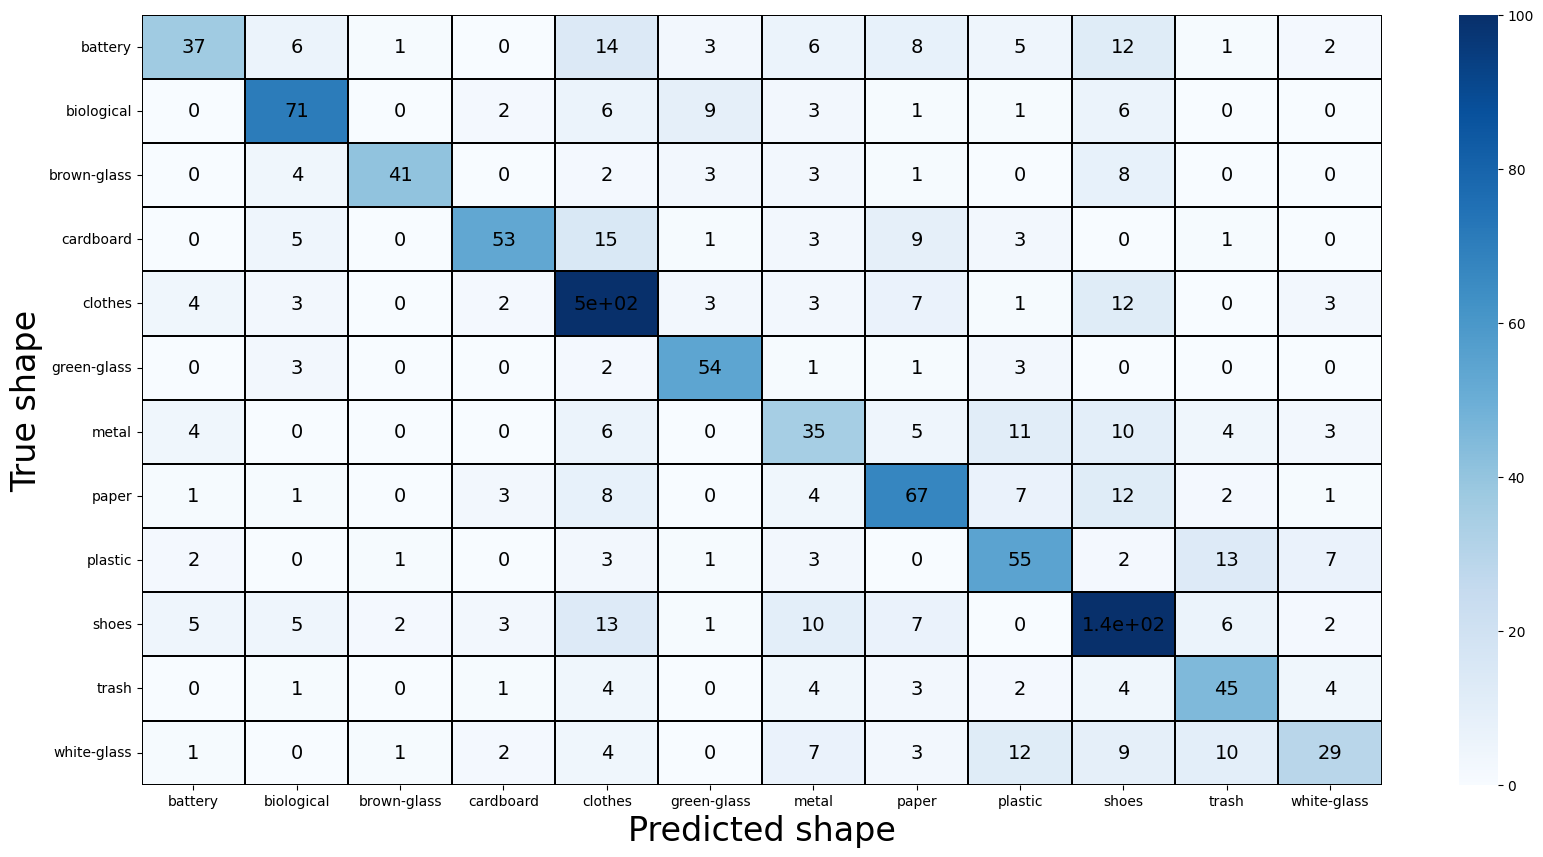

              precision    recall  f1-score   support

           0       0.69      0.39      0.50        95
           1       0.72      0.72      0.72        99
           2       0.89      0.66      0.76        62
           3       0.80      0.59      0.68        90
           4       0.87      0.93      0.90       533
           5       0.72      0.84      0.78        64
           6       0.43      0.45      0.44        78
           7       0.60      0.63      0.61       106
           8       0.55      0.63      0.59        87
           9       0.66      0.73      0.69       199
          10       0.55      0.66      0.60        68
          11       0.57      0.37      0.45        78

    accuracy                           0.72      1559
   macro avg       0.67      0.63      0.64      1559
weighted avg       0.72      0.72      0.72      1559



In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
#import numpy as np

#classes = ['fire', 'smoke']
cm = confusion_matrix(truelabels, predictions)
#tick_marks = np.arange(len(classes))
df_cm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (20,10))
annot_kws={'fontsize':14,
           'color':"k",
           'verticalalignment':'center'}

sns.heatmap(df_cm, annot = True, annot_kws = annot_kws, cmap ='Blues', vmin = 0, vmax = 100, linewidth = 0.2, linecolor = 'k')
plt.xlabel('Predicted shape', fontsize = 24)
plt.ylabel('True shape', fontsize = 24)
plt.show()

print(classification_report(truelabels, predictions))


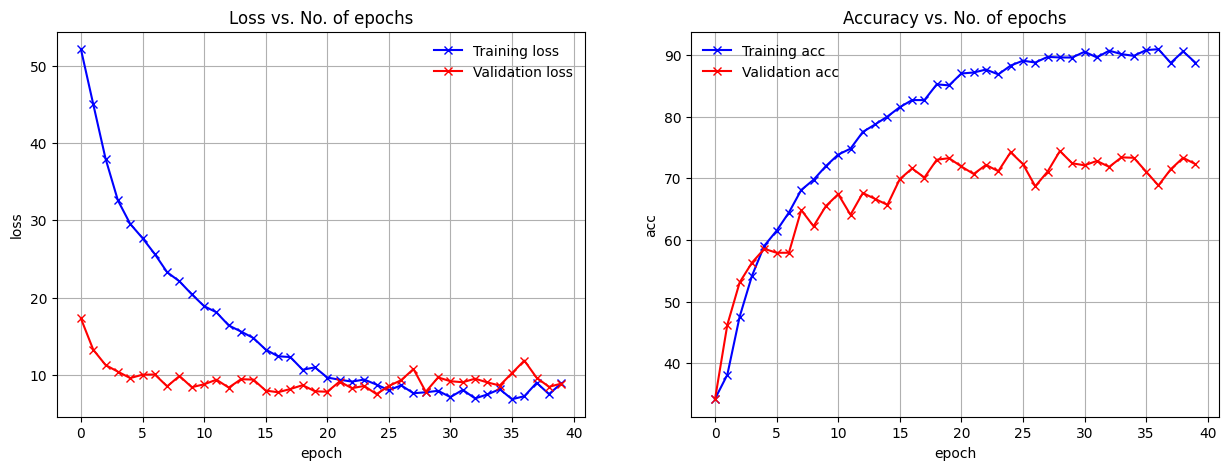

In [9]:
plt.figure(1, figsize = (15,5))
# Plot loss
plt.subplot(1,2,1)
plt.plot(train_losses, '-bx', label = 'Training loss')
plt.plot(valid_losses, '-rx', label = 'Validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs')
plt.grid()
plt.legend(frameon = False)

# Plot accuracy
plt.subplot(1,2,2)
plt.plot(train_acc, '-bx', label = 'Training acc')
plt.plot(valid_acc, '-rx', label = 'Validation acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Accuracy vs. No. of epochs')
plt.legend(frameon = False)
plt.grid()
plt.show()